## Observations:

zip is available in address - index on split is -1, -5:

potential interests:

- zip code (reduced to large(-ish?) sample sizes)
- maybe look at geographical location specifically? (Is proximity to city center and features calculable?| $\checkmark$)
  - look into part 2 ^
  - waterfront is listed as a binary column
- (person pref, focus on home buyers/individuals)
- someone mentioned school data - this isn't a bad idea.
  - can get school rankings and their zip codes

would like to get external/additional information. Will check Kaggle for related data sets

https://kingcounty.gov/ <= city website

find out if prices are based on closes or valuations - if closes, can

### Data cleaning

- multiple y/n / cat. columns that can be converted to dummies for OLS discovery
- view quality can be rated as good/bad/avg. , could be extrapolated to 0-2 (more if more options there)
- grade?

<hr/>
Data from [column_names.md](data/column_names.md)  
vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv

- `view` - Quality of view from house
  - Includes views of Mt. Rainier, Olympics, Cascades, Territorial, Seattle Skyline, Puget Sound, Lake Washington, Lake Sammamish, small lake / river / creek, and other
- `condition` - How good the overall condition of the house is. Related to maintenance of house.
  - See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each condition code
- `grade` - Overall grade of the house. Related to the construction and design of the house.
  - See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each building grade code
  <hr/>

lots of relevant info for discovery in there


# _*IMPORTANT*_

Most fields were pulled from the [King County Assessor Data Download](https://info.kingcounty.gov/assessor/DataDownload/default.aspx).

The `address`, `lat`, and `long` fields have been retrieved using a third-party [geocoding API](https://docs.mapbox.com/api/search/geocoding/). In some cases due to missing or incorrectly-entered data from the King County Assessor, this API returned locations outside of King County, WA. If you plan to use the `address`, `lat`, or `long` fields in your modeling, consider identifying outliers prior to including the values in your model

<br/><hr/><br/><hr/>


### imports


In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from code.features import has_feature
import numpy as np
from random import gauss, seed
from scipy import stats
import seaborn as sns
from mpl_toolkits import mplot3d
import sklearn.metrics as metrics
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

dfs:  
    housing data - provided by FlatIron School  
    zip codes: cross referenced with zip-codes.com  
    nearby_zips - pulled from https://gis-kingcounty.opendata.arcgis.com/datasets/kingcounty::zipcodes-for-king-county-and-surrounding-area-zipcode-area/

In [109]:
housing_df = pd.read_csv('data/kc_house_data.csv')
zip_codes = pd.read_csv('data/King_County_Zip_Codes.csv')
nearby_zips_df = pd.read_csv('data/counties_5_mile.csv')

## Variable Definitions

In [110]:
sns.set()

In [111]:
alpha = 0.05            # default confidence 
upper_cost = 5000000    # <= $5,000,

## DataFrame Definitions

In [112]:
housing_df['zip'] = housing_df['address'].map(lambda x: x.split(',')[-2][-5:])
housing_df['town']= housing_df['address'].map(lambda x: x.split(',')[-3].strip())
housing_df.drop(columns=['address','lat','long', 'heat_source', 'grade', 'sewer_system', 'nuisance'], inplace = True)
kc_only = housing_df.merge(zip_codes['Zip Codes'].astype(str),left_on='zip',right_on='Zip Codes',how='inner')

In [113]:
display(kc_only.describe(), kc_only.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29189 entries, 0 to 29188
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             29189 non-null  int64  
 1   date           29189 non-null  object 
 2   price          29189 non-null  float64
 3   bedrooms       29189 non-null  int64  
 4   bathrooms      29189 non-null  float64
 5   sqft_living    29189 non-null  int64  
 6   sqft_lot       29189 non-null  int64  
 7   floors         29189 non-null  float64
 8   waterfront     29189 non-null  object 
 9   greenbelt      29189 non-null  object 
 10  view           29189 non-null  object 
 11  condition      29189 non-null  object 
 12  sqft_above     29189 non-null  int64  
 13  sqft_basement  29189 non-null  int64  
 14  sqft_garage    29189 non-null  int64  
 15  sqft_patio     29189 non-null  int64  
 16  yr_built       29189 non-null  int64  
 17  yr_renovated   29189 non-null  int64  
 18  zip   

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated
count,2.918900e+04,2.918900e+04,29189.000000,29189.000000,29189.000000,2.918900e+04,29189.000000,29189.000000,29189.000000,29189.000000,29189.000000,29189.000000,29189.000000
mean,4.535750e+09,1.113059e+06,3.435335,2.331889,2130.911987,1.720745e+04,1.516564,1825.949844,480.890747,336.257666,216.342972,1973.827401,93.931344
std,2.882323e+09,8.957550e+05,0.978759,0.896124,977.502626,6.131060e+04,0.548233,880.928042,586.056457,286.283099,246.810496,31.681435,422.974700
min,1.000055e+06,2.736000e+04,0.000000,0.000000,3.000000,4.020000e+02,1.000000,2.000000,0.000000,0.000000,0.000000,1900.000000,0.000000
25%,2.085201e+09,6.450000e+05,3.000000,2.000000,1440.000000,5.000000e+03,1.000000,1190.000000,0.000000,0.000000,40.000000,1952.000000,0.000000
50%,3.874000e+09,8.685000e+05,3.000000,2.500000,1940.000000,7.560000e+03,1.500000,1580.000000,0.000000,400.000000,140.000000,1976.000000,0.000000
75%,7.287100e+09,1.310000e+06,4.000000,3.000000,2640.000000,1.078400e+04,2.000000,2290.000000,960.000000,510.000000,310.000000,2001.000000,0.000000
max,9.904000e+09,3.075000e+07,13.000000,10.500000,15360.000000,3.253932e+06,4.000000,12660.000000,8020.000000,3580.000000,4370.000000,2022.000000,2022.000000


None

In [114]:
new_columns = ['has_basement', 'has_garage', 'has_patio', 'is_renovated']
check_columns = ['sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_renovated']
kc_only[new_columns] = kc_only[check_columns].apply(has_feature)
kc_only['sell_year'] = kc_only['date'].map(lambda x: x.split('/')[-1][-4:])
kc_only['sell_age'] = kc_only['sell_year'].astype(int) - kc_only['yr_built'].astype(int)
kc_only.drop(columns=check_columns, inplace=True)
kc_only.drop('sqft_above', axis = 1, inplace=True)
kc_only.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,yr_built,zip,town,Zip Codes,has_basement,has_garage,has_patio,is_renovated,sell_year,sell_age
0,7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,1969,98055,Renton,98055,0,0,1,0,2022,53
1,3340401570,3/2/2022,750000.0,3,2.0,1830,7969,1.0,NO,NO,...,1950,98055,Renton,98055,1,1,1,1,2022,72
2,7399301200,3/29/2022,728000.0,4,2.0,2170,7520,1.0,NO,NO,...,1973,98055,Renton,98055,1,1,1,0,2022,49
3,9899200050,3/24/2022,565000.0,4,2.0,1400,10364,1.5,NO,NO,...,1971,98055,Renton,98055,0,1,1,0,2022,51
4,6673070070,12/28/2021,645000.0,3,2.0,1520,8250,1.0,NO,NO,...,1981,98055,Renton,98055,1,1,1,0,2021,40


excluding < 400sqft, tiny home by definition per:
"A dwelling unit that is 400 square feet (37 m2) or less in floor area excluding sleeping lofts"
src: https://www.seattle.gov/documents/Departments/SDCI/Codes/SeattleResidentialCode/2018SRCAppendixQ.pdf


Create homes_df, which only includes houses over 400sqft - which is the point where a house becomes a tiny home.

Additionally, we are only looking at houses that have a bathroom and a bedroom, as well we are cutting off anything above our upper cost range, $5,000,000 in this case.

In [115]:
homes_df = kc_only[(kc_only['sqft_living'] > 400) &
    (kc_only['bedrooms'] > 0) &
    (kc_only['bathrooms'] > 0) &
    (kc_only['price'] < upper_cost)                        # <= dropping houses valued at and over $5,000,000 - most demographics will not be looking for this.
    ]

### Adding Condition Variable
Transforming condition into numeric variable 0-4. We are ordinarly encoding this to make it a numeric variable from a category to a numeric and keeping the natural ordering system of: 
- Poor = 0
- Fair = 1
- Average = 2
- Good = 3
- Very Good = 4

In [116]:
homes_df['condition'].value_counts() #checking out what is in the condition column 

Average      17405
Good          7996
Very Good     3238
Fair           222
Poor            58
Name: condition, dtype: int64

In [117]:
#creating its own dataframe for simplicity 
condition_df = pd.DataFrame(homes_df['condition'])
condition_df 

,condition
0,Good
1,Average
2,Average
3,Good
4,Average
...,...
29184,Very Good
29185,Average
29186,Fair
29187,Average


In [118]:
categories = [['Poor', 'Fair', 'Average', 'Good', 'Very Good']]
ords = OrdinalEncoder(categories=categories)
ords.fit(condition_df)
condition_df['condition'] = ords.transform(condition_df)
condition_df

,condition
0,3.0
1,2.0
2,2.0
3,3.0
4,2.0
...,...
29184,4.0
29185,2.0
29186,1.0
29187,2.0


In [119]:
homes_df['condition_numeric'] = condition_df['condition']
homes_df.head() #checking out new column

<ipython-input-119-3970a1d45664>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  homes_df['condition_numeric'] = condition_df['condition']


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,zip,town,Zip Codes,has_basement,has_garage,has_patio,is_renovated,sell_year,sell_age,condition_numeric
0,7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,98055,Renton,98055,0,0,1,0,2022,53,3.0
1,3340401570,3/2/2022,750000.0,3,2.0,1830,7969,1.0,NO,NO,...,98055,Renton,98055,1,1,1,1,2022,72,2.0
2,7399301200,3/29/2022,728000.0,4,2.0,2170,7520,1.0,NO,NO,...,98055,Renton,98055,1,1,1,0,2022,49,2.0
3,9899200050,3/24/2022,565000.0,4,2.0,1400,10364,1.5,NO,NO,...,98055,Renton,98055,0,1,1,0,2022,51,3.0
4,6673070070,12/28/2021,645000.0,3,2.0,1520,8250,1.0,NO,NO,...,98055,Renton,98055,1,1,1,0,2021,40,2.0


In [120]:
homes_df.info()
#numeric: price, bedrooms, bathrooms, sqft_living, sqft_lot, floors,  
#sqft_above,  sqft_basement, sqft_garage  , sqft_patio, yr_built, yr_renovated   

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28919 entries, 0 to 29188
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 28919 non-null  int64  
 1   date               28919 non-null  object 
 2   price              28919 non-null  float64
 3   bedrooms           28919 non-null  int64  
 4   bathrooms          28919 non-null  float64
 5   sqft_living        28919 non-null  int64  
 6   sqft_lot           28919 non-null  int64  
 7   floors             28919 non-null  float64
 8   waterfront         28919 non-null  object 
 9   greenbelt          28919 non-null  object 
 10  view               28919 non-null  object 
 11  condition          28919 non-null  object 
 12  yr_built           28919 non-null  int64  
 13  zip                28919 non-null  object 
 14  town               28919 non-null  object 
 15  Zip Codes          28919 non-null  object 
 16  has_basement       289

Create a dataframe that only has housing data where there are at least 100 houses in a given zip code  
This is to ensure that there is substantial explanatory information when investigating the zip code's effect on pricing later.

In [121]:
# get zip codes that have at least 100 entries

zip_counts = homes_df['zip'].value_counts().rename('zip_counts')
zips_counted = homes_df.merge(
    zip_counts,
    left_on='zip',
    right_index=True
)
zips_counted.info()
min_zips = zips_counted[zips_counted['zip_counts'] >= 100]
min_zips


<class 'pandas.core.frame.DataFrame'>
Int64Index: 28919 entries, 0 to 29188
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 28919 non-null  int64  
 1   date               28919 non-null  object 
 2   price              28919 non-null  float64
 3   bedrooms           28919 non-null  int64  
 4   bathrooms          28919 non-null  float64
 5   sqft_living        28919 non-null  int64  
 6   sqft_lot           28919 non-null  int64  
 7   floors             28919 non-null  float64
 8   waterfront         28919 non-null  object 
 9   greenbelt          28919 non-null  object 
 10  view               28919 non-null  object 
 11  condition          28919 non-null  object 
 12  yr_built           28919 non-null  int64  
 13  zip                28919 non-null  object 
 14  town               28919 non-null  object 
 15  Zip Codes          28919 non-null  object 
 16  has_basement       289

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,town,Zip Codes,has_basement,has_garage,has_patio,is_renovated,sell_year,sell_age,condition_numeric,zip_counts
0,7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,Renton,98055,0,0,1,0,2022,53,3.0,219
1,3340401570,3/2/2022,750000.0,3,2.0,1830,7969,1.0,NO,NO,...,Renton,98055,1,1,1,1,2022,72,2.0,219
2,7399301200,3/29/2022,728000.0,4,2.0,2170,7520,1.0,NO,NO,...,Renton,98055,1,1,1,0,2022,49,2.0,219
3,9899200050,3/24/2022,565000.0,4,2.0,1400,10364,1.5,NO,NO,...,Renton,98055,0,1,1,0,2022,51,3.0,219
4,6673070070,12/28/2021,645000.0,3,2.0,1520,8250,1.0,NO,NO,...,Renton,98055,1,1,1,0,2021,40,2.0,219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29092,723039050,12/16/2021,1826000.0,2,3.0,2070,71264,2.0,NO,NO,...,Vashon,98070,1,1,1,0,2021,20,2.0,193
29093,2022039037,4/14/2022,256000.0,2,1.0,1330,113815,1.0,NO,NO,...,Vashon,98070,0,1,0,1,2022,111,3.0,193
29094,2322039033,7/14/2021,950000.0,2,2.5,1960,11406,2.0,NO,NO,...,Vashon,98070,1,1,1,1,2021,83,2.0,193
29095,3023039221,9/21/2021,450000.0,2,2.0,840,138520,1.0,NO,NO,...,Vashon,98070,0,0,1,0,2021,1,2.0,193


In [122]:
display(homes_df.info(), min_zips.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28919 entries, 0 to 29188
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 28919 non-null  int64  
 1   date               28919 non-null  object 
 2   price              28919 non-null  float64
 3   bedrooms           28919 non-null  int64  
 4   bathrooms          28919 non-null  float64
 5   sqft_living        28919 non-null  int64  
 6   sqft_lot           28919 non-null  int64  
 7   floors             28919 non-null  float64
 8   waterfront         28919 non-null  object 
 9   greenbelt          28919 non-null  object 
 10  view               28919 non-null  object 
 11  condition          28919 non-null  object 
 12  yr_built           28919 non-null  int64  
 13  zip                28919 non-null  object 
 14  town               28919 non-null  object 
 15  Zip Codes          28919 non-null  object 
 16  has_basement       289

None

None

Create a dataframe of zip codes that are sorted by their median price descending, this is useful for finding the highest-priced zip code to use as a reference point when investigating zip code effect on price.

In [123]:
# reduce df to only zip codes with at least 100 reported houses
zip_by_price_median = min_zips[
    ['zip', 'price']].groupby(by='zip').agg(
        {'price': 'median', 'zip': 'size'}
).rename(
    columns={'zip': 'count'}
).reset_index()
zip_by_price_median.sort_values('price', ascending=False, inplace=True)
zip_by_price_median

,zip,price,count
3,98004,2672500.0,258
24,98040,2300000.0,323
4,98005,1956000.0,178
21,98033,1832687.5,600
38,98075,1830500.0,410
...,...,...,...
12,98022,567230.0,454
2,98003,550000.0,439
20,98032,549950.0,183
63,98168,540000.0,383


In [124]:
numeric_homes = homes_df[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',  'has_patio', 'has_garage', 
                          'has_basement', 'sell_age','is_renovated', 'condition_numeric']]   

In [125]:
numeric_homes

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,has_patio,has_garage,has_basement,sell_age,is_renovated,condition_numeric
0,675000.0,4,1.0,1180,7140,1.0,1,0,0,53,0,3.0
1,750000.0,3,2.0,1830,7969,1.0,1,1,1,72,1,2.0
2,728000.0,4,2.0,2170,7520,1.0,1,1,1,49,0,2.0
3,565000.0,4,2.0,1400,10364,1.5,1,1,0,51,0,3.0
4,645000.0,3,2.0,1520,8250,1.0,1,1,1,40,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
29184,750000.0,3,1.0,1530,33250,1.5,1,0,1,117,0,4.0
29185,315000.0,1,1.0,480,7475,1.0,0,0,0,113,1,2.0
29186,250000.0,2,1.0,1040,114998,1.0,0,0,0,93,0,1.0
29187,202000.0,2,1.0,1260,11160,1.5,1,0,0,103,0,2.0


Dropping unnecessary columns for the purposes of our exploration: Address, Waterfront, 

In [126]:
homes_df.corr() ##looking for most correlated variable to our y which is price

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,has_basement,has_garage,has_patio,is_renovated,sell_age,condition_numeric
id,1.000000,-0.033166,-0.004319,-0.010386,-0.027170,-0.120351,0.035503,0.023282,0.005075,0.034470,0.002365,-0.028393,-0.023398,-0.008982
price,-0.033166,1.000000,0.344295,0.519019,0.652976,0.090865,0.244477,0.120453,0.112179,0.140572,0.178392,0.082623,-0.118997,-0.004448
bedrooms,-0.004319,0.344295,1.000000,0.588299,0.638138,-0.001498,0.197586,0.182272,0.077205,0.222475,0.168366,0.008534,-0.182645,0.016591
bathrooms,-0.010386,0.519019,0.588299,1.000000,0.771820,0.035482,0.435888,0.462627,0.118471,0.341518,0.288591,0.037621,-0.463081,-0.067227
sqft_living,-0.027170,0.652976,0.638138,0.771820,1.000000,0.120270,0.361965,0.333704,0.094511,0.297304,0.279003,0.029899,-0.334051,-0.070536
sqft_lot,-0.120351,0.090865,-0.001498,0.035482,0.120270,1.000000,-0.020532,0.013326,-0.042196,-0.018744,0.030986,0.008329,-0.013422,-0.004803
floors,0.035503,0.244477,0.197586,0.435888,0.361965,-0.020532,1.000000,0.522107,-0.192773,0.141990,0.204968,-0.015921,-0.522134,-0.267426
yr_built,0.023282,0.120453,0.182272,0.462627,0.333704,0.013326,0.522107,1.000000,-0.279108,0.490582,0.191699,-0.237160,-0.999885,-0.303894
has_basement,0.005075,0.112179,0.077205,0.118471,0.094511,-0.042196,-0.192773,-0.279108,1.000000,-0.098733,0.085264,0.056072,0.278884,0.068363
has_garage,0.034470,0.140572,0.222475,0.341518,0.297304,-0.018744,0.141990,0.490582,-0.098733,1.000000,0.118117,-0.122983,-0.490545,-0.081415


<AxesSubplot:>

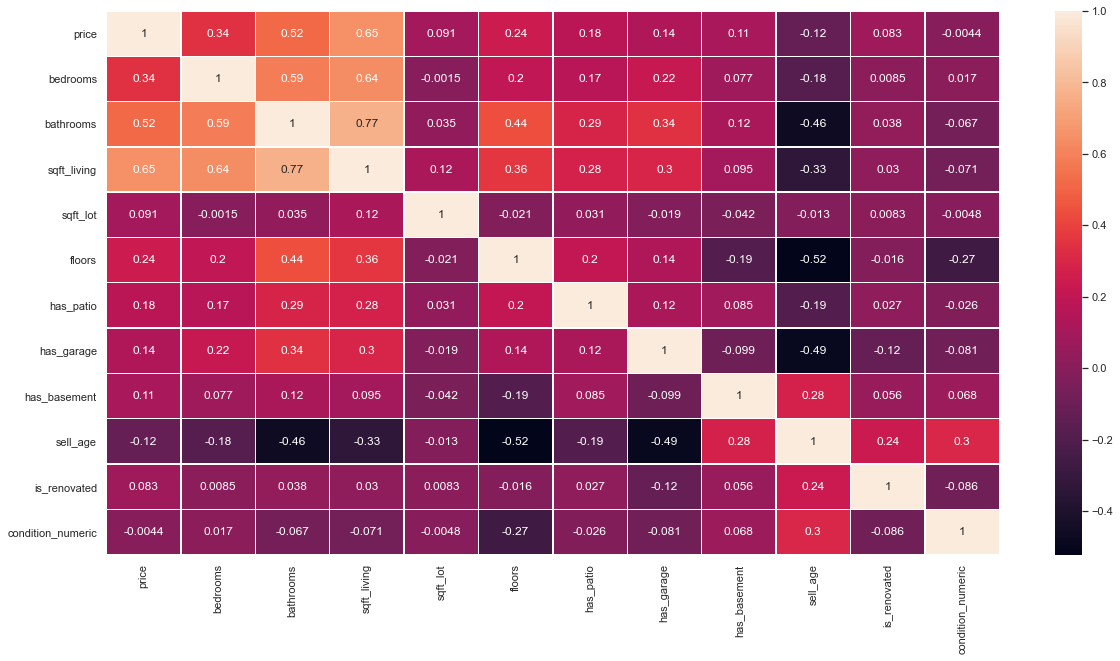

In [127]:
#heatmaps with correlation

plt.figure(figsize = (20,10))
sns.heatmap(numeric_homes.corr(), annot = True, linewidths=.5)


# Running simple regression based on most correlated variable of sqft_living

In [135]:
#run a simple regression on this correlation
x = homes_df['sqft_living']
y = homes_df['price']
simple_model = sm.OLS(y, sm.add_constant(x)).fit()
sm_summary = simple_model.summary()
sm_summary #shows a low rquared at .426 but model is significant. for every 1 sqft change, price increases by 568

#note kurtosis is 8, no need ot log Y 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                 2.149e+04
Date:                Wed, 29 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:10:20   Log-Likelihood:            -4.2060e+05
No. Observations:               28919   AIC:                         8.412e+05
Df Residuals:                   28917   BIC:                         8.412e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         8.84e+04   7307.379     12.098      0.000    7.41e+04    1.03e+05
sqft_living   463.8170      3.164    146.609      0.000     457.616     470.018
==============================================================================
Omnibus:                     8853.834   Durbin-Watson:                   1.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            47301.463
Skew:                           1.377   Prob(JB):                         0.00
Kurtosis:                       8.627   Cond. No.                     5.72e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot:>

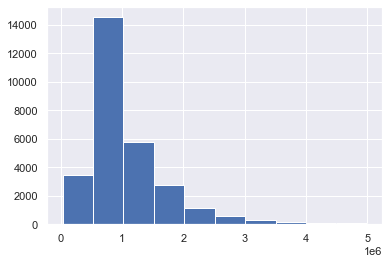

In [129]:
y.hist() #looking at skew. almost normal distbution, will not log Y. 

In [136]:
#looking at model of all numeric variables within dataset
x2 = numeric_homes.drop(['price'], axis = 1)
model = sm.OLS(y, sm.add_constant(x2)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     2224.
Date:                Wed, 29 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:13:35   Log-Likelihood:            -4.1977e+05
No. Observations:               28919   AIC:                         8.396e+05
Df Residuals:                   28907   BIC:                         8.397e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -1.67e+05    2.1e+04     -7.971      0.000   -2.08e+05   -1.26e+05
bedrooms          -1.022e+05   4006.513    -25.504      0.000    -1.1e+05   -9.43e+04
bathrooms          9.667e+04   5999.711     16.113      0.000    8.49e+04    1.08e+05
sqft_living         482.0024      5.323     90.553      0.000     471.569     492.435
sqft_lot              0.0949      0.048      1.966      0.049       0.000       0.189
floors             7.944e+04   6716.841     11.827      0.000    6.63e+04    9.26e+04
has_patio         -1.195e+04   7262.194     -1.645      0.100   -2.62e+04    2284.632
has_garage         5185.3558   7316.746      0.709      0.479   -9155.803    1.95e+04
has_basement       1.528e+04   6394.787      2.389      0.017    2745.753    2.78e+04
sell_age           3286.8587    140.892     23.329      0.000    3010.704    3563.013
is_renovated         7.8e+04   1.46e+04      5.341      0.000    4.94e+04    1.07e+05
condition_numeric   2.41e+04   4418.498      5.455      0.000    1.54e+04    3.28e+04
==============================================================================
Omnibus:                     8792.914   Durbin-Watson:                   1.144
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            50584.570
Skew:                           1.343   Prob(JB):                         0.00
Kurtosis:                       8.896   Cond. No.                     4.76e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.76e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Note that the has garage, has_patio are  both are statistically insignificant and will remove the two and rerun. 
sqft lot almost insignificant but will remain in model. Skew went down. 

In [139]:
x3 = numeric_homes.drop(['price', 'has_garage', 'has_patio'], axis = 1)
log_model2 = sm.OLS(y, sm.add_constant(x3)).fit()
log_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     2717.
Date:                Wed, 29 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:15:55   Log-Likelihood:            -4.1978e+05
No. Observations:               28919   AIC:                         8.396e+05
Df Residuals:                   28909   BIC:                         8.397e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -1.67e+05   1.95e+04     -8.575      0.000   -2.05e+05   -1.29e+05
bedrooms          -1.019e+05   4002.368    -25.470      0.000    -1.1e+05   -9.41e+04
bathrooms          9.643e+04   5984.274     16.114      0.000    8.47e+04    1.08e+05
sqft_living         481.5134      5.283     91.139      0.000     471.158     491.869
sqft_lot              0.0917      0.048      1.903      0.057      -0.003       0.186
floors             7.762e+04   6561.041     11.830      0.000    6.48e+04    9.05e+04
has_basement       1.408e+04   6358.540      2.214      0.027    1613.549    2.65e+04
sell_age           3265.2527    128.822     25.347      0.000    3012.755    3517.750
is_renovated       7.683e+04   1.46e+04      5.267      0.000    4.82e+04    1.05e+05
condition_numeric  2.388e+04   4411.038      5.413      0.000    1.52e+04    3.25e+04
==============================================================================
Omnibus:                     8792.370   Durbin-Watson:                   1.144
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            50547.834
Skew:                           1.343   Prob(JB):                         0.00
Kurtosis:                       8.894   Cond. No.                     4.41e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.41e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Note: SQFT lot no longer statistically significant. 

In [142]:
x4 = numeric_homes.drop(['price', 'has_garage', 'has_patio', 'sqft_lot'], axis = 1)
multi_model = sm.OLS(y, sm.add_constant(x4)).fit()
mm_summary = multi_model.summary()
mm_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     3056.
Date:                Wed, 29 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:19:22   Log-Likelihood:            -4.1978e+05
No. Observations:               28919   AIC:                         8.396e+05
Df Residuals:                   28910   BIC:                         8.396e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1.639e+05   1.94e+04     -8.446      0.000   -2.02e+05   -1.26e+05
bedrooms          -1.026e+05   3985.180    -25.758      0.000    -1.1e+05   -9.48e+04
bathrooms          9.598e+04   5979.875     16.051      0.000    8.43e+04    1.08e+05
sqft_living         483.2485      5.204     92.855      0.000     473.048     493.449
floors             7.678e+04   6546.460     11.728      0.000    6.39e+04    8.96e+04
has_basement       1.331e+04   6345.946      2.097      0.036     868.235    2.57e+04
sell_age           3266.2261    128.827     25.354      0.000    3013.719    3518.733
is_renovated       7.694e+04   1.46e+04      5.274      0.000    4.83e+04    1.06e+05
condition_numeric  2.383e+04   4411.175      5.402      0.000    1.52e+04    3.25e+04
==============================================================================
Omnibus:                     8812.675   Durbin-Watson:                   1.146
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            50792.617
Skew:                           1.346   Prob(JB):                         0.00
Kurtosis:                       8.909   Cond. No.                     1.61e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [140]:
x5 = numeric_homes[['is_renovated', 'sell_age','sqft_living']]
multi_model = sm.OLS(y, sm.add_constant(x5)).fit()
mm_summary = multi_model.summary()
mm_summary #this is a lower adj R, but conditioning number is much lower since less variables. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     7536.
Date:                Wed, 29 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:17:19   Log-Likelihood:            -4.2029e+05
No. Observations:               28919   AIC:                         8.406e+05
Df Residuals:                   28915   BIC:                         8.406e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -6.659e+04   1.02e+04     -6.553      0.000   -8.65e+04   -4.67e+04
is_renovated  1.203e+05   1.44e+04      8.363      0.000    9.21e+04    1.49e+05
sell_age      2111.2298    101.282     20.845      0.000    1912.712    2309.748
sqft_living    486.9623      3.344    145.630      0.000     480.408     493.516
==============================================================================
Omnibus:                     8697.302   Durbin-Watson:                   1.107
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            47797.381
Skew:                           1.341   Prob(JB):                         0.00
Kurtosis:                       8.698   Cond. No.                     1.15e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Multi regression model using zip codes 

Create an OLS model that describes the zip code's ability to describe price. Output this as a dataframe object that can be called and indexed into.

In [143]:
y = homes_df['price']
X = sm.add_constant(
    pd.get_dummies(homes_df['zip']).drop(
        zip_by_price_median.iloc[0]['zip'],         # <= selectl the highest-(median) priced zip to drop it
        axis=1
    ))

zip_model = sm.OLS(np.log(y), X).fit().summary2()
display(zip_by_price_median.iloc[0],print(zip_model))

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.446     
Dependent Variable: price            AIC:                31726.1058
Date:               2023-03-29 15:22 BIC:                32354.7971
No. Observations:   28919            Log-Likelihood:     -15787.   
Df Model:           75               F-statistic:        310.8     
Df Residuals:       28843            Prob (F-statistic): 0.00      
R-squared:          0.447            Scale:              0.17492   
---------------------------------------------------------------------
            Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
---------------------------------------------------------------------
const      14.7461     0.0260   566.3280   0.0000   14.6950   14.7971
98001      -1.4719     0.0310   -47.5374   0.0000   -1.5326   -1.4112
98002      -1.7263     0.0340   -50.7191   0.0000   -1.7930   -1.6596
98003      -1.5283     0.0328   -46.5817   0.0000   -1

zip           98004
price    2.6725e+06
count           258
Name: 3, dtype: object

None

Create two graphs, one that displays the value of prices by zip code and one that 

''

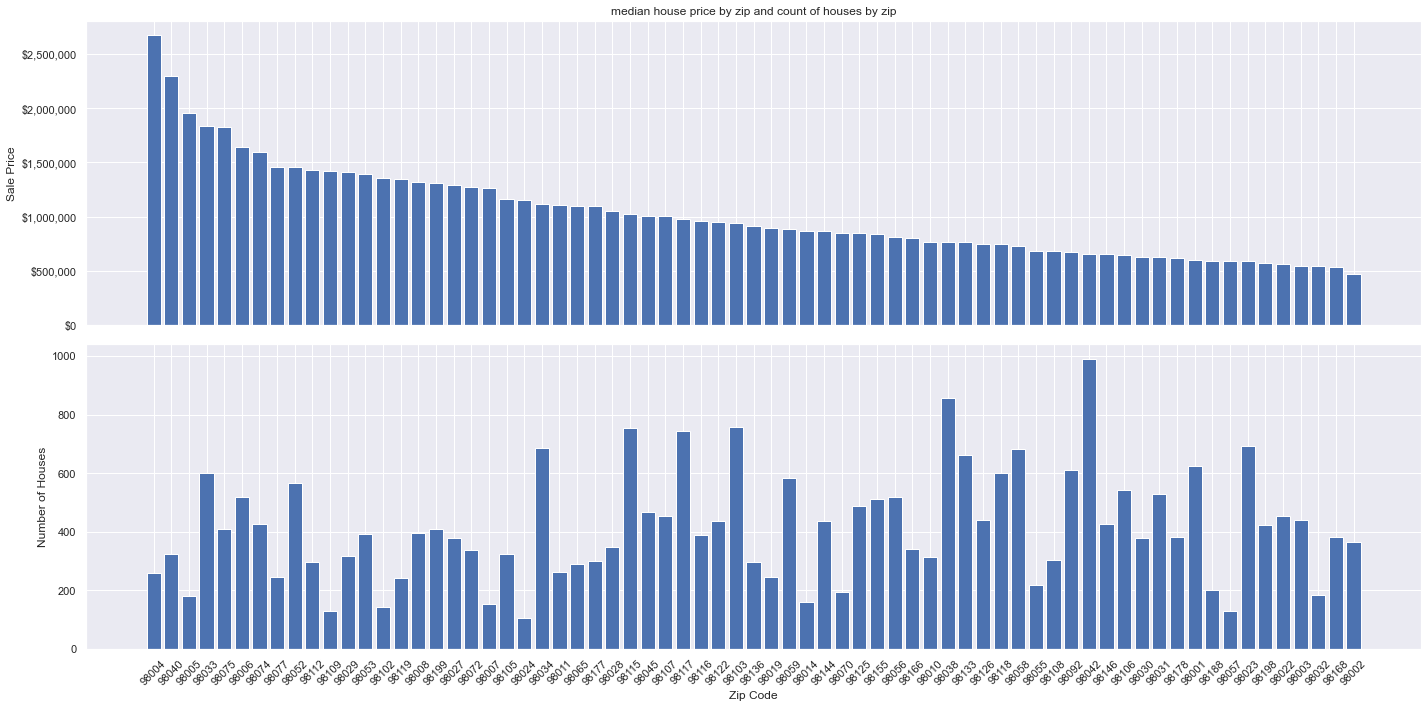

In [ ]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(20, 10))

y = [zip_by_price_median['price'], zip_by_price_median['count']]
x = zip_by_price_median['zip']

ax[0].bar(x=x, height=y[0])
ax[1].bar(x=x, height=y[1])

ax[0].set(
    title='median house price by zip and count of houses by zip',
    ylabel='Sale Price'
)
ax[1].set(
    ylabel='Number of Houses',
    xlabel='Zip Code',
)

dollar_format = mtick.StrMethodFormatter('${x:,.0f}')
ax[0].yaxis.set_major_formatter(dollar_format)
plt.xticks(rotation=45)
plt.tight_layout()
''